In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scipy

import networkx as nx

In [9]:
sc.settings.set_figure_params(dpi_save=1200, vector_friendly=True, fontsize=18)
plt.rcParams['axes.grid'] = False

In [3]:
from decipher_model import DecipherConfig, Decipher
from load_data import palette_original

from post_analysis import rotate_decipher_space, cluster_representations, compute_trajectories, compute_decipher_time
from post_analysis_plotting import plot_decipher_v, plot_trajectory, plot_gene_patterns, add_cell_type_band

## Load trained model

In [4]:
adata = sc.read_h5ad("data/AML3.decipher.h5ad")
n_genes = adata.shape[1]

cvi_config = DecipherConfig(
    seed=0,
    learning_rate=1e-3,
)
model = Decipher(
    genes_dim=n_genes,
    decipher_config=cvi_config,
)
model.load_state_dict(torch.load("data/AML3.decipher.pth"))
model.eval();


# compatibility - to do in original adata
adata.obsm["decipher_v"] = adata.obsm["latent_p"]
adata.obsm["decipher_z"] = adata.obsm["latent_z"]
adata.obs["origin"] = adata.obs["origin"].replace({"tet2_p3":"AML3", "healthy": "Healthy"})

V4


In [5]:
adata.obs["origin_int"] = adata.obs["origin"].replace({"AML3": 1, "Healthy": 0})
rotate_decipher_space(
    adata, "origin_int", decipher_component_to_align_label_with=2, flip_latent_z=True, flip_decipher_1=True
)

/opt/miniconda3/envs/latent-manifold/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'origin' as categorical


<AxesSubplot:title={'center':'cell_type_merged'}, xlabel='decipher_v_corrected1', ylabel='decipher_v_corrected2'>

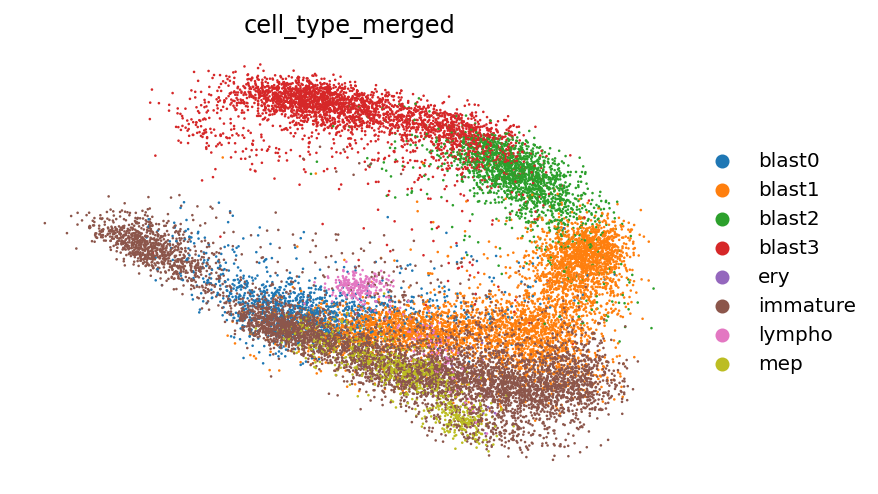

In [6]:
sc.pl.embedding(
        adata,
        basis="decipher_v_corrected",
        color=["cell_type_merged"],
        vmax=lambda xs: np.quantile(xs, 0.95),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False
    )

/opt/miniconda3/envs/latent-manifold/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


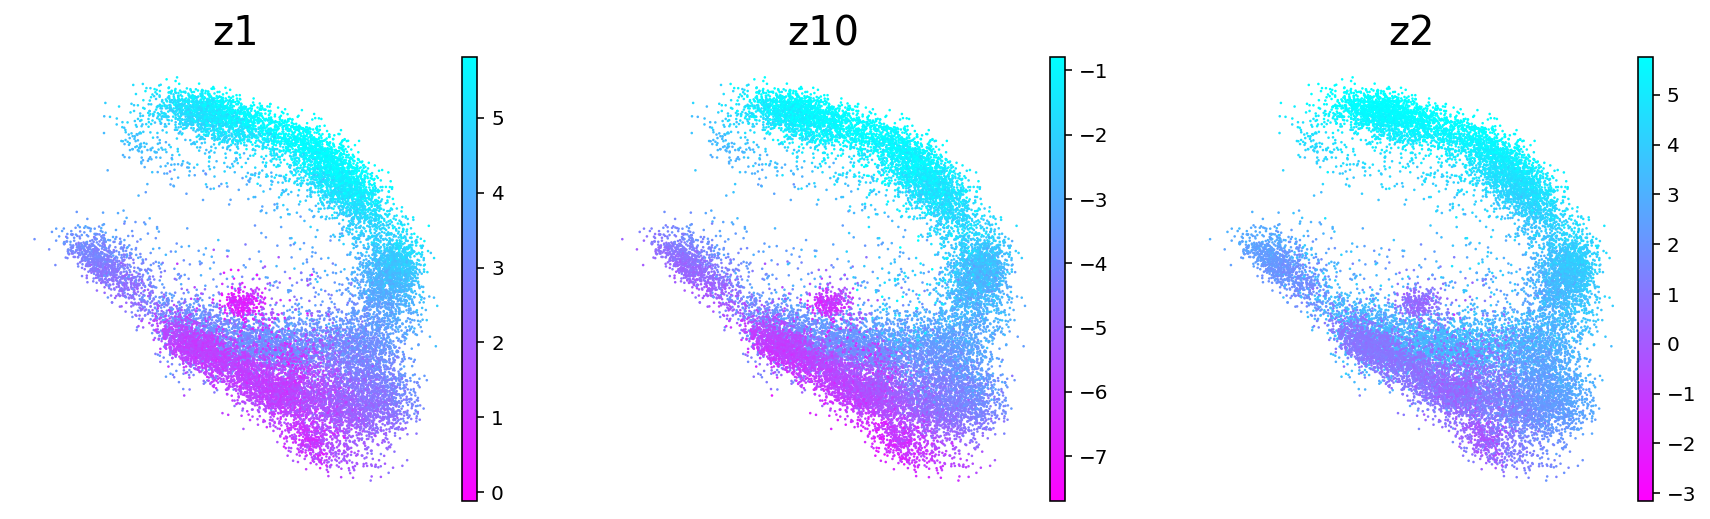

In [7]:
with plt.rc_context({'axes.titlesize':20 , 'axes.labelsize':0, 'figure.figsize': [4,4]}):
    for i in range(10):
        adata.obs["z%d" % (i+1)] = adata.obsm["decipher_z_corrected"][:,i]
    sc.pl.embedding(
        adata,
        basis="decipher_v_corrected",
        color=["z%d" % (i) for i in [1,10,2]],
        vmax=lambda xs: np.quantile(xs, 0.95),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False
    )
    plt.tight_layout()

# plt.savefig("figures/figure3/figure3.D.part1.pdf")


In [8]:
cluster_representations(adata)
normal_trajectory = compute_trajectories(
    adata,
    "AVP",
    "MPO",
    subset_column="origin",
    subset_value="Healthy",
    cell_types_key="cell_type_merged",
)
perturbed_trajectory = compute_trajectories(
    adata,
    "AVP",
    "CD68",
    subset_column="origin",
    subset_value="AML3",
    cell_types_key="cell_type_merged",
)

In [9]:
sc.write("analysis/AML3.decipher.post-analyzed.h5ad", adata)
import pickle
with open("analysis/AML3.trajectory.normal.pkl", "wb") as f:
    pickle.dump(normal_trajectory, f)
    
with open("analysis/AML3.trajectory.perturbed.pkl", "wb") as f:
    pickle.dump(perturbed_trajectory, f)

Only considering the two last: ['.post-analyzed', '.h5ad'].
Only considering the two last: ['.post-analyzed', '.h5ad'].


In [10]:
adata = sc.read_h5ad("analysis/AML3.decipher.post-analyzed.h5ad")
import pickle
with open("analysis/AML3.trajectory.normal.pkl", "rb") as f:
    normal_trajectory = pickle.load(f)
    
with open("analysis/AML3.trajectory.perturbed.pkl", "rb") as f:
    perturbed_trajectory = pickle.load(f)

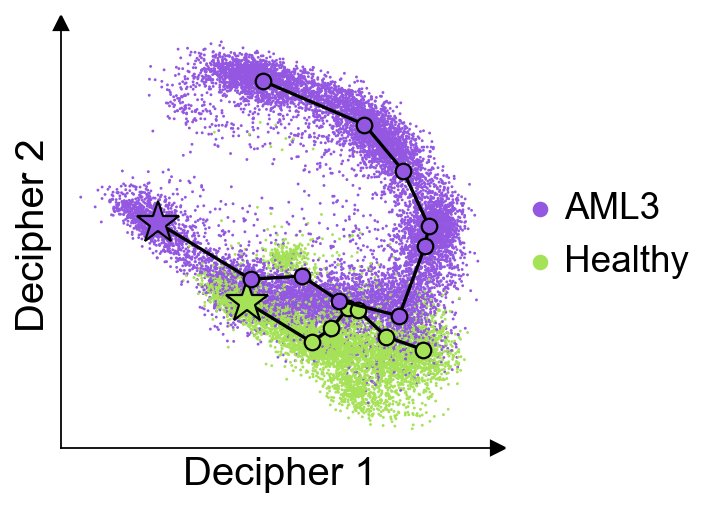

In [10]:
fig = plot_decipher_v(adata, "origin", palette=palette_original)
plot_trajectory(
    fig.axes[0],
    normal_trajectory,
    color=palette_original["Healthy"],
)

plot_trajectory(
    fig.axes[0],
    perturbed_trajectory,
    color=palette_original["AML3"],
)
fig.savefig("figures/extended_figure3/AML3.decipher_space.origin.pdf", bbox_inches="tight")

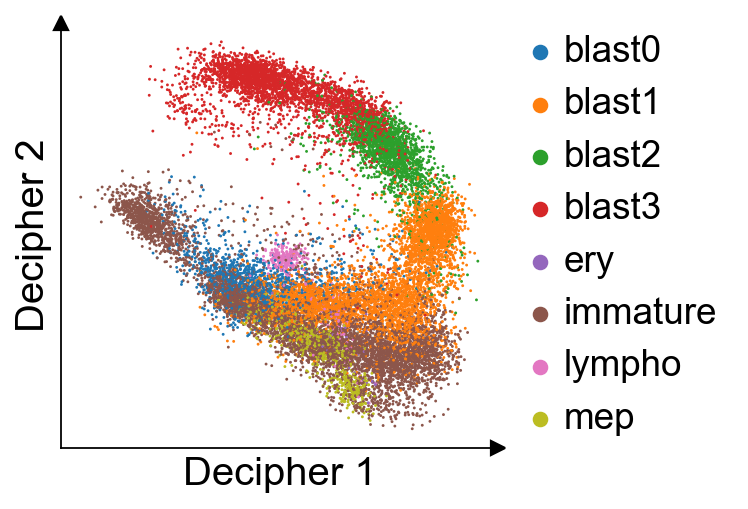

In [11]:
fig = plot_decipher_v(adata, "cell_type_merged")
fig.savefig("figures/extended_figure3/AML3.decipher_space.cell_type.pdf", bbox_inches="tight")

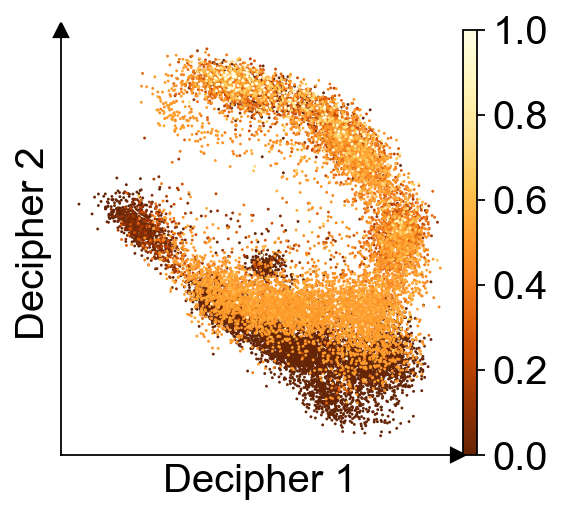

In [12]:
fig = plot_decipher_v(adata, "NPM1 mutation vs wild type", cmap=sns.color_palette("YlOrBr_r", as_cmap=True, ))
fig.savefig("figures/extended_figure3/AML3.decipher_space.mutation.pdf", bbox_inches="tight")

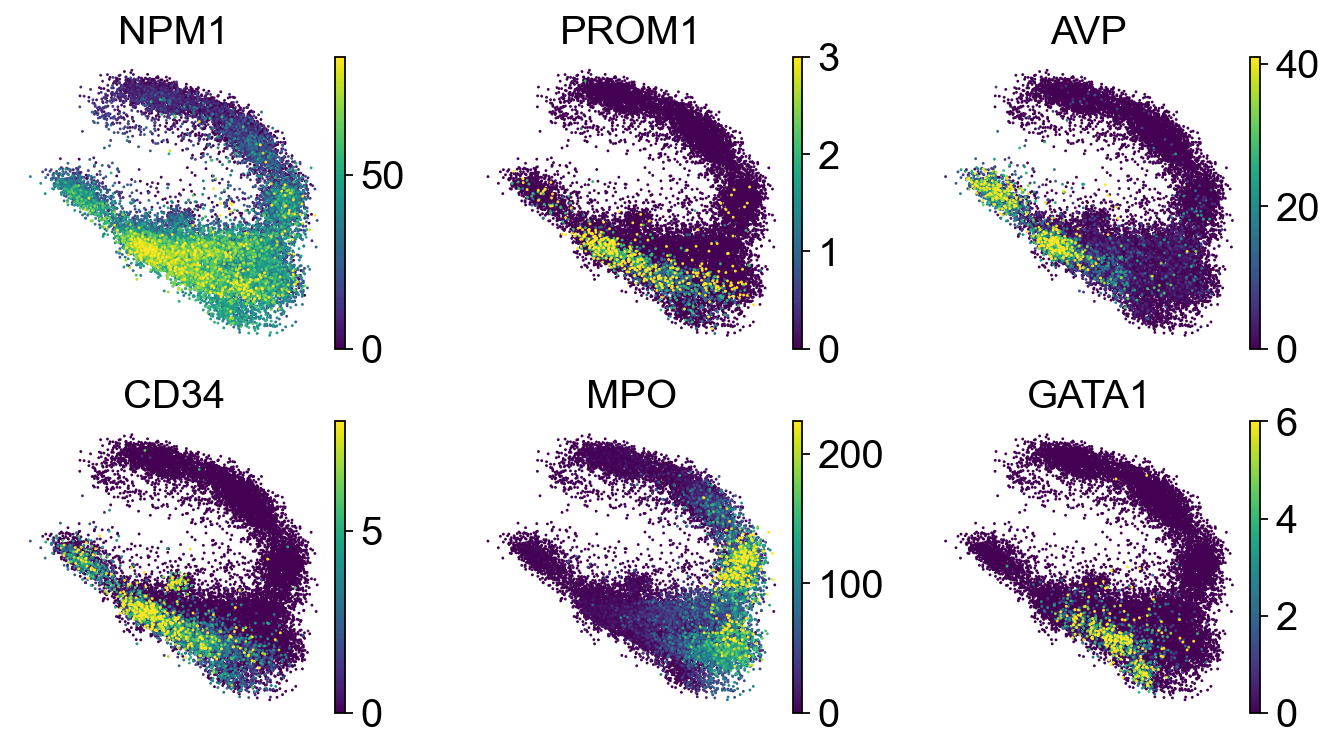

In [13]:
fig = plot_decipher_v(
    adata,
    ["NPM1", "PROM1", "AVP", "CD34", "MPO", "GATA1"],
    show_axis="no",
    ncols=3,
    vmax=lambda x: np.quantile(x, 0.99),
    figsize=(2.5, 2.5),
)
fig.savefig("figures/extended_figure3/AML3.decipher_space.gene_expression.pdf", bbox_inches='tight')

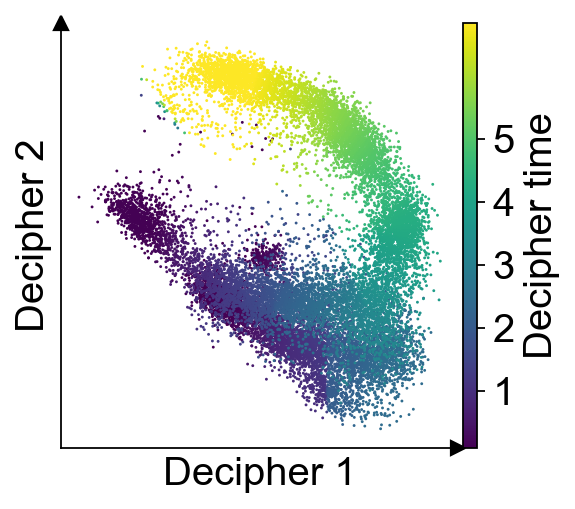

In [14]:
compute_decipher_time(
    adata, {"Healthy": normal_trajectory, "AML3": perturbed_trajectory}
)

fig = plot_decipher_v(adata, "decipher_time")
fig.axes[0].collections[-1].colorbar.set_label("Decipher time")
fig.axes[0].collections[-1].colorbar.set_ticks([0,1,2,3,4,5])
fig.savefig("figures/extended_figure3/AML3.decipher_space.decipher_time.pdf", bbox_inches='tight')

In [15]:
from post_analysis import gene_patterns_from_decipher_trajectory

gene_patterns_from_decipher_trajectory(adata, model)

# we now compare patterns only on their overlapping portions
reference_times = None
min_length = 1_000_000
gene_patterns = []
keys = []
for key in adata.uns["decipher_gene_patterns"]:
    keys.append(key)
    patterns_df = adata.uns["decipher_gene_patterns"][key].T
    if patterns_df.shape[1] < min_length:
        reference_times = patterns_df.columns.values
        min_length = patterns_df.shape[1]
    gene_patterns.append(patterns_df.values)

gene_patterns = np.stack([gg[:, :min_length] for gg in gene_patterns])
adata.uns["decipher_gene_patterns_cropped"] = {
    "patterns": gene_patterns,
    "times": reference_times,
    "keys": keys,
}

In [16]:
from basis_decomposition.run import compute_basis_decomposition, InferenceMode, plot_basis, get_basis

gene_patterns = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["patterns"])
gene_patterns_times = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["times"])

trajectory_model, guide, times, samples, gene_scales = compute_basis_decomposition(
    gene_patterns,
    InferenceMode.GAUSSIAN_BETA_ONLY,
    n_basis=5,
    n_iter=10_000,
    show_basis=False,
    lr=1e-2,
    beta_prior=1,
    seed=0,
    times=gene_patterns_times
)
gene_scales = gene_scales.detach().numpy()
betas = samples["beta"]["mean"].squeeze().detach().numpy()
basis = get_basis(trajectory_model, guide, gene_patterns, times)
adata.uns["decipher_basis_decomposition"] = {"scales": gene_scales, "betas": betas, "basis": basis}

[iteration 0001] loss: 423675.0984 0.13094070553779602 tensor(0.1159)
[iteration 0101] loss: 70945.9575 0.08336381614208221 tensor(0.0738)
[iteration 0201] loss: -126652.7937 0.03435162827372551 tensor(0.0304)
[iteration 0301] loss: -360383.0781 0.010480008088052273 tensor(0.0093)
[iteration 0401] loss: -455976.9413 0.007817688398063183 tensor(0.0069)
[iteration 0501] loss: -500362.6603 0.0069274017587304115 tensor(0.0061)
[iteration 0601] loss: -523632.8397 0.006471292581409216 tensor(0.0057)
[iteration 0701] loss: -543456.8984 0.005770678631961346 tensor(0.0051)
[iteration 0801] loss: -572475.5011 0.0050143348053097725 tensor(0.0044)
[iteration 0901] loss: -593760.3871 0.004189770668745041 tensor(0.0037)
[iteration 1001] loss: -621447.2092 0.0035089014563709497 tensor(0.0031)
[iteration 1101] loss: -637460.4413 0.0031429126393049955 tensor(0.0028)
[iteration 1201] loss: -651153.7730 0.0028511453419923782 tensor(0.0025)
[iteration 1301] loss: -699652.6437 0.0021029948256909847 tensor(

In [21]:
sc.write("analysis/AML3.decipher.post-analyzed.h5ad", adata)


Only considering the two last: ['.post-analyzed', '.h5ad'].
Only considering the two last: ['.post-analyzed', '.h5ad'].


Text(0.5, 0, 'Decipher time')

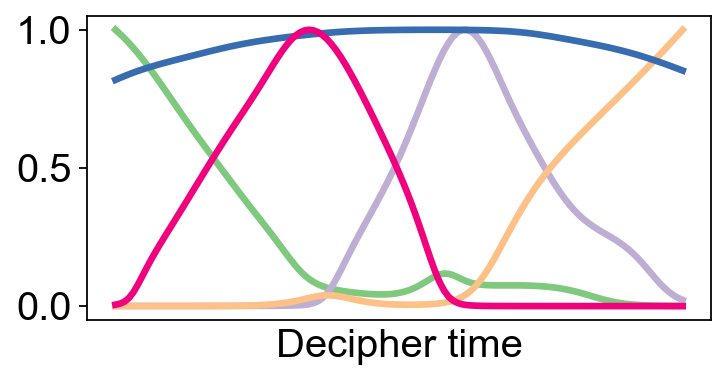

In [17]:
with plt.rc_context({"figure.figsize": [5,2.5]}):
    colors = sns.color_palette("Accent")
    colors = [colors[i] for i in [0, 1, 2, 4, 5]]
    plot_basis(trajectory_model, guide, gene_patterns, times, colors);
plt.xticks([])
plt.xlabel("Decipher time")
# plt.savefig(f"figures/figure3/AML2.basis.pdf",  bbox_inches="tight")

In [16]:
n_samples = 100
normal_gene_patterns_samples = sample_from_decipher_trajectory(
    adata, model, normal_trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)
perturbed_gene_patterns_samples = sample_from_decipher_trajectory(
    adata, model, perturbed_trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)


normal_gene_patterns_mean = sample_from_decipher_trajectory(
    adata, model, normal_trajectory.trajectory_latent, smooth=0, return_mean=True
).T
perturbed_gene_patterns_mean = sample_from_decipher_trajectory(
    adata, model, perturbed_trajectory.trajectory_latent, smooth=0, return_mean=True
).T
min_length = min(normal_gene_patterns_mean.shape[1], perturbed_gene_patterns_mean.shape[1])

gene_patterns = torch.stack(
    [
        normal_gene_patterns_mean[:, :min_length], 
        perturbed_gene_patterns_mean[:, :min_length],
    ]
)
gene_patterns_raw = gene_patterns.clone()
gene_patterns = (
    gene_patterns - gene_patterns.mean(axis=[0,2], keepdim=True)
) / gene_patterns.std(axis=[0,2], keepdim=True)

torch.save(
    {"gene_patterns_zscore": gene_patterns, "gene_patterns_raw": gene_patterns_raw},
    "AML3.gene_patterns.pt",
)

In [17]:
def plot_gene_patterns_normal_perturbed(gene_name):
    plot_gene_patterns(
        gene_name,
        adata,
        [normal_trajectory, perturbed_trajectory],
        [normal_gene_patterns_samples, perturbed_gene_patterns_samples],
        [palette_original["Healthy"], palette_original["AML1"]],
        ["Normal", "Perturbed"],
    )
    add_cell_type_band(perturbed_trajectory, palette_original)

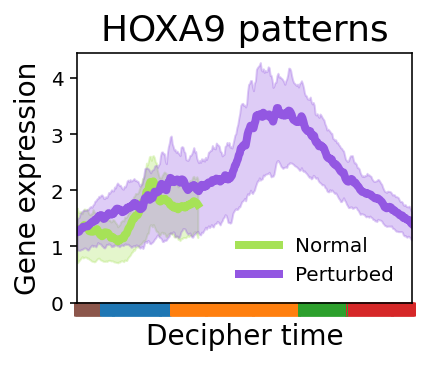

In [19]:
plot_gene_patterns_normal_perturbed(
    "HOXA9",
)


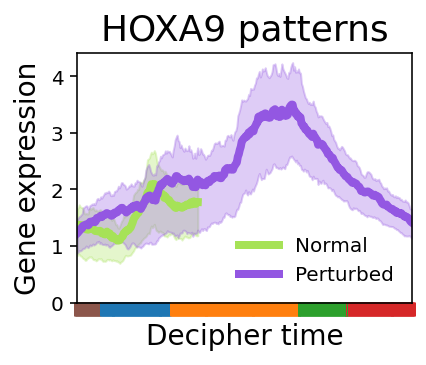

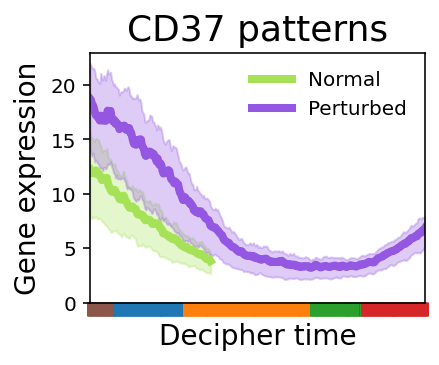

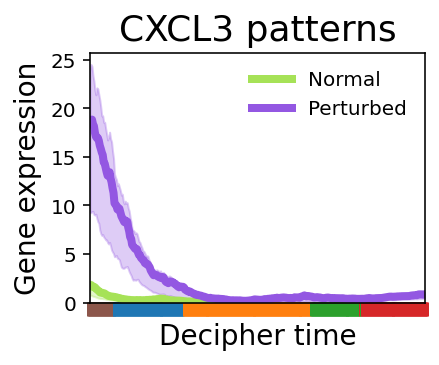

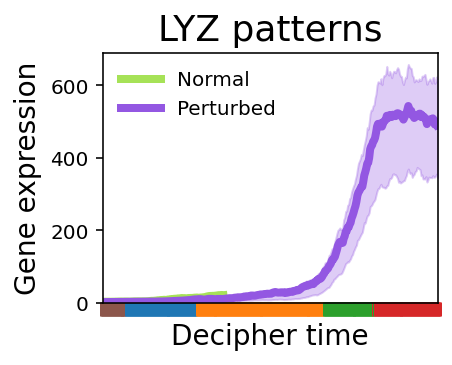

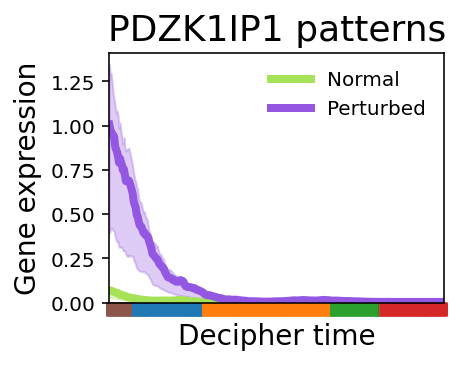

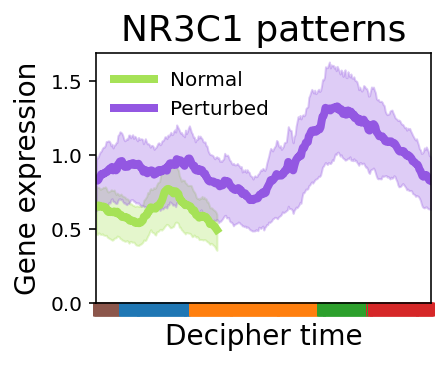

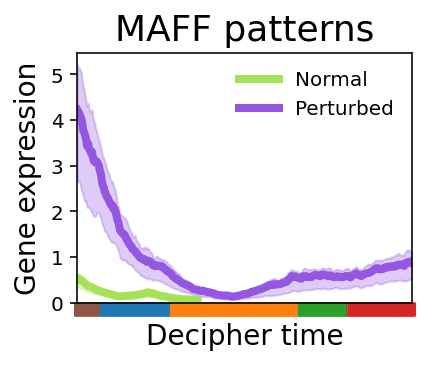

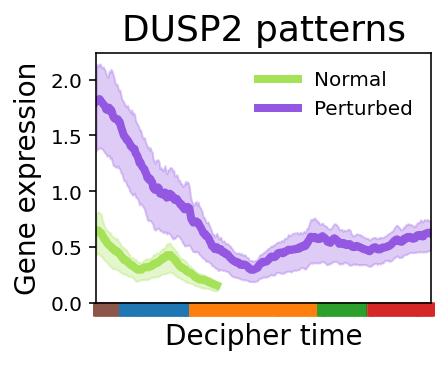

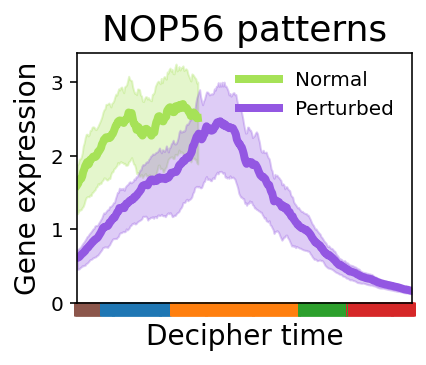

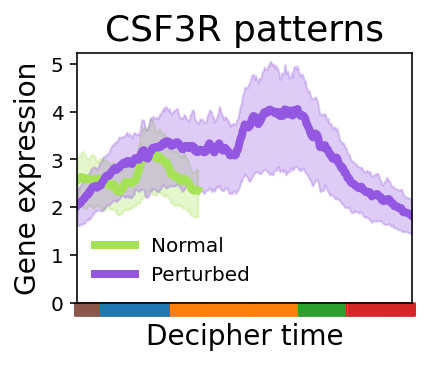

In [18]:
for g in [
    "HOXA9",
    "CD37",
    "CXCL3",
    "LYZ",
    "PDZK1IP1",
    "NR3C1",
#     "ZBTB10",
    "MAFF",
    "DUSP2",
    "NOP56",
    "CSF3R",
#     "TNFRSF12A",
]:
    plot_gene_patterns_normal_perturbed(g)
#     plt.savefig(f"figures/figure4/figure4.a.part1.{g}.pdf", bbox_inches="tight")